In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier
import funcs
from sklearn.metrics import roc_curve, auc, confusion_matrix

In [79]:
data = pd.read_csv("../../adni/objects/adni_df.csv", index_col=0)
data.head()

,RID,PTHAND,PTMARRY,PTEDUCAT,PTNOTRT,PTHOME,PTPLANG,PTETHCAT,PTRACCAT,age,...,RCT29,RCT3,RCT392,RCT4,RCT5,RCT6,RCT8,RCT9,apoe,DIAGNOSIS
1,2,2,1,16,1,1,1,2,5,74.333333,...,0.2,19,1.1,21,19,15,5.6,3.0,2,Control
2,3,1,1,18,1,3,1,2,5,81.250000,...,0.1,21,1.3,16,19,19,6.9,3.5,3,AZ
3,4,1,1,10,0,1,2,1,5,67.583333,...,0.1,16,1.2,23,18,25,6.0,2.9,2,MCI
4,5,1,1,16,1,1,1,2,5,73.666667,...,0.2,16,1.0,17,24,14,5.7,3.2,2,Control
5,6,1,1,13,1,1,1,2,5,80.416667,...,0.2,19,1.1,16,19,23,5.3,4.5,2,MCI


In [81]:
df = data.copy()

In [85]:
df = funcs.preproc_df(df)

In [87]:
outcome = df['DIAGNOSIS']
df.drop('DIAGNOSIS', axis = 1, inplace=True)

In [89]:
outcome_mapping = {"Control": 0,
                  "MCI": 1,
                  "AZ": 2}
outcome = outcome.map(outcome_mapping)

In [91]:
cat_features = [col for col in df.columns if (
    col.startswith("NX") or
    col.startswith("PX") or
    col.startswith("PT") or
    col.startswith("MH") or
    (col.startswith("GD") and col != "GDTOTAL") or
    col in specific
)]

In [93]:
specific = ["mother", "father", "HMSCORE", "BPCAT", 'apoe']

## Baseline model with all features

In [95]:
X, X_test, y, y_test = train_test_split(df, outcome, test_size=0.2, random_state=43)

In [97]:
smote_over = SMOTE(random_state=44)
X, y = smote_over.fit_resample(X, y)

In [64]:
best_params = {'iterations': 1300, 
               'learning_rate': 0.1014738735791829, 
               'l2_leaf_reg': 1.113932097894264, 
               'bagging_temperature': 0.5824798842949885, 
               'random_strength': 1.117577499175244, 
               'depth': 6,
               'random_seed': 42,
               'loss_function': "MultiClass",
               'min_data_in_leaf': 77, 
               'colsample_bylevel': 0.7599261618674156}

In [66]:
final_model = CatBoostClassifier(**best_params, verbose=False, cat_features=cat_features)

In [99]:
final_model.fit(X, y)

In [100]:
predictions = final_model.predict(X_test)
predictions_proba = final_model.predict_proba(X_test)

In [101]:
funcs.metrics_merged(y_test, predictions, predictions_proba)

,Class,Recall,Precision,Specificity,NPV,AUC
0,Control,0.930233,0.816327,0.931818,0.976190,0.978330
1,MCI,0.783505,0.826087,0.794872,0.746988,0.855670
2,AD,0.628571,0.647059,0.914286,0.907801,0.897347


In [105]:
confusion_matrix(y_test, predictions)

array([[40,  3,  0],
       [ 9, 76, 12],
       [ 0, 13, 22]], dtype=int64)

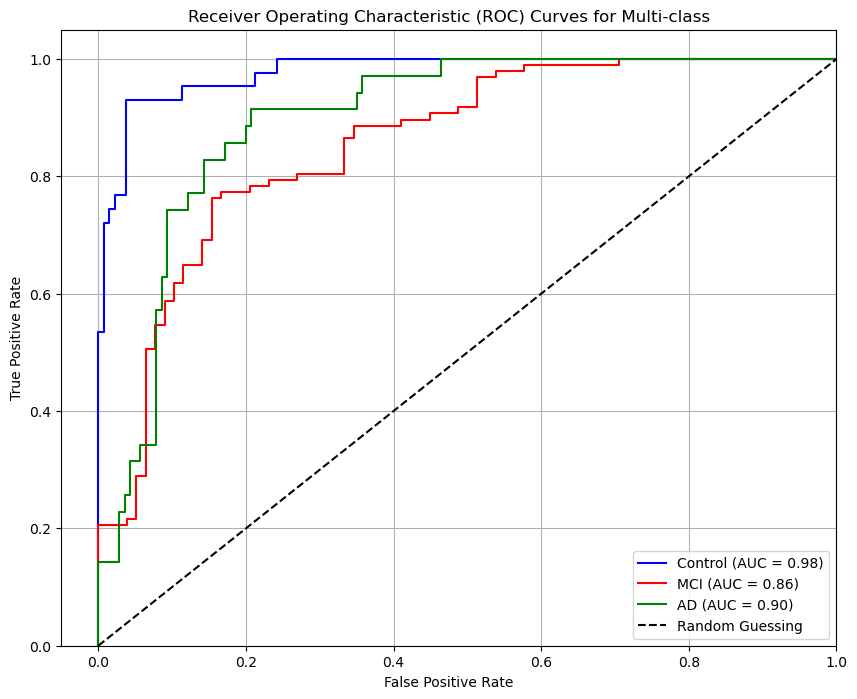

In [107]:
n_classes = len(np.unique(y_test))
class_labels = ["Control", "MCI", "AD"]
colors = ['blue', 'red', 'green']  


plt.figure(figsize=(10, 8))

for i in range(n_classes):

    fpr, tpr, _ = roc_curve(y_test == i, predictions_proba[:, i])  
    roc_auc = auc(fpr, tpr)  

    # Plot ROC curve
    plt.plot(fpr, tpr, color=colors[i], label=f'{class_labels[i]} (AUC = {roc_auc:.2f})')


plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing') 
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves for Multi-class')
plt.legend(loc='lower right')
plt.grid()
plt.show()

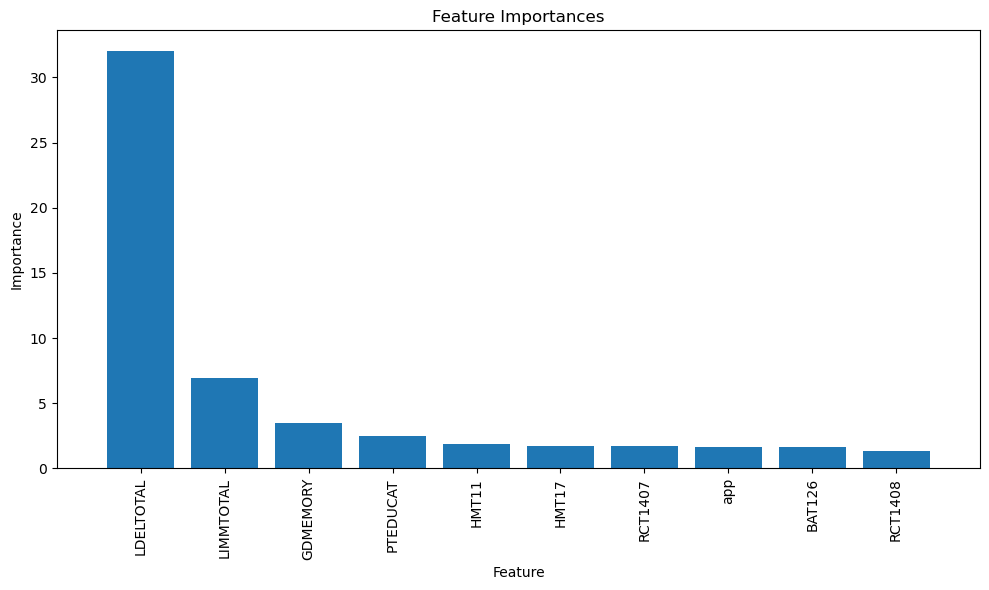

In [109]:
importances = final_model.feature_importances_
feature_names = X.columns  # If using a DataFrame, otherwise, use the appropriate feature list

# Sort feature importances
indices = np.argsort(importances)[::-1][:10]
# Create a bar plot of feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(10), importances[indices], align="center")
plt.xticks(range(10), feature_names[indices], rotation=90)
plt.xlim([-1, 10])
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.tight_layout()
plt.show()